#**<center><font color="red">Indian-Sign-Language-Detection</center>**

#**PROBLEM STATEMENT**
- To prepare a complete data analysis and deep learning-based classification report on the given **Indian Sign Language (ISL)** alphabet dataset.

- To build and evaluate a Convolutional Neural Network (CNN) model that classifies ISL hand gesture images into their respective alphabet categories, assisting in the development of communication tools for the deaf and hard-of-hearing community in India.

#**DOMAIN ANALYSIS AND DATA INFORMATION**
- **Indian Sign Language (ISL)** is an essential mode of communication for the deaf and hard-of-hearing communities in India. Hand gesture recognition through computer vision plays a crucial role in enabling machine interpretation and translation of ISL into text or speech.

- Challenges in ISL classification include variations in hand shape, lighting conditions, background clutter, and image orientation. A reliable model can significantly improve the quality of interaction for those relying on sign language, bridging communication gaps.

---
#**CLASSES**
- The dataset contains 24 distinct classes images, each corresponding to a letter in the English alphabet (A–Z), except for 2 missing letters **(J,Z)**.

- Total Classes: **24**

- Classes: 'A', 'B', 'C', ..., 'Y' (excluding J, Z)



#**1. MOUNTING THE DRIVE**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**2. IMPORTING LIBRARIES**

In [ ]:
import cv2
import os
import zipfile
import shutil
import random
from PIL import Image

import pathlib
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization

from sklearn.metrics import classification_report,confusion_matrix

#**3. EXTRACTING DATASET FROM ZIP FILE**

In [ ]:
with zipfile.ZipFile("/content/drive/MyDrive/IndianSignLangProject/PRAICP-1000-IndiSignLang.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/drive/MyDrive/IndianSignLangProject")

#**4. BASIC CHECKS**

In [ ]:
data_path = "/content/drive/MyDrive/IndianSignLangProject/Data"
num_classes = len(os.listdir(data_path))

In [ ]:
image_counts = {}
total_images = 0

# Count all files in each folder
for folder in sorted(os.listdir(data_path)):
    folder_path = os.path.join(data_path, folder)
    if os.path.isdir(folder_path):
        count = len(os.listdir(folder_path))
        image_counts[folder] = count
        total_images += count

# Print image counts
print("Image counts per class:\n")
for folder in sorted(image_counts):
    print(f"Class '{folder}': {image_counts[folder]} images")

print("\n")
print(f"Total folders (classes): {len(image_counts)}")

print(f"\nTotal images: {total_images}")

Image counts per class:

Class 'A': 242 images
Class 'B': 259 images
Class 'C': 247 images
Class 'D': 147 images
Class 'E': 243 images
Class 'F': 226 images
Class 'G': 241 images
Class 'H': 116 images
Class 'I': 179 images
Class 'K': 245 images
Class 'L': 182 images
Class 'M': 235 images
Class 'N': 237 images
Class 'O': 229 images
Class 'P': 234 images
Class 'Q': 216 images
Class 'R': 211 images
Class 'S': 229 images
Class 'T': 216 images
Class 'U': 135 images
Class 'V': 122 images
Class 'W': 128 images
Class 'X': 202 images
Class 'Y': 251 images


Total folders (classes): 24

Total images: 4972


#**5. VISUALIZING ALL THE CLASSES (24 CLASSES)**

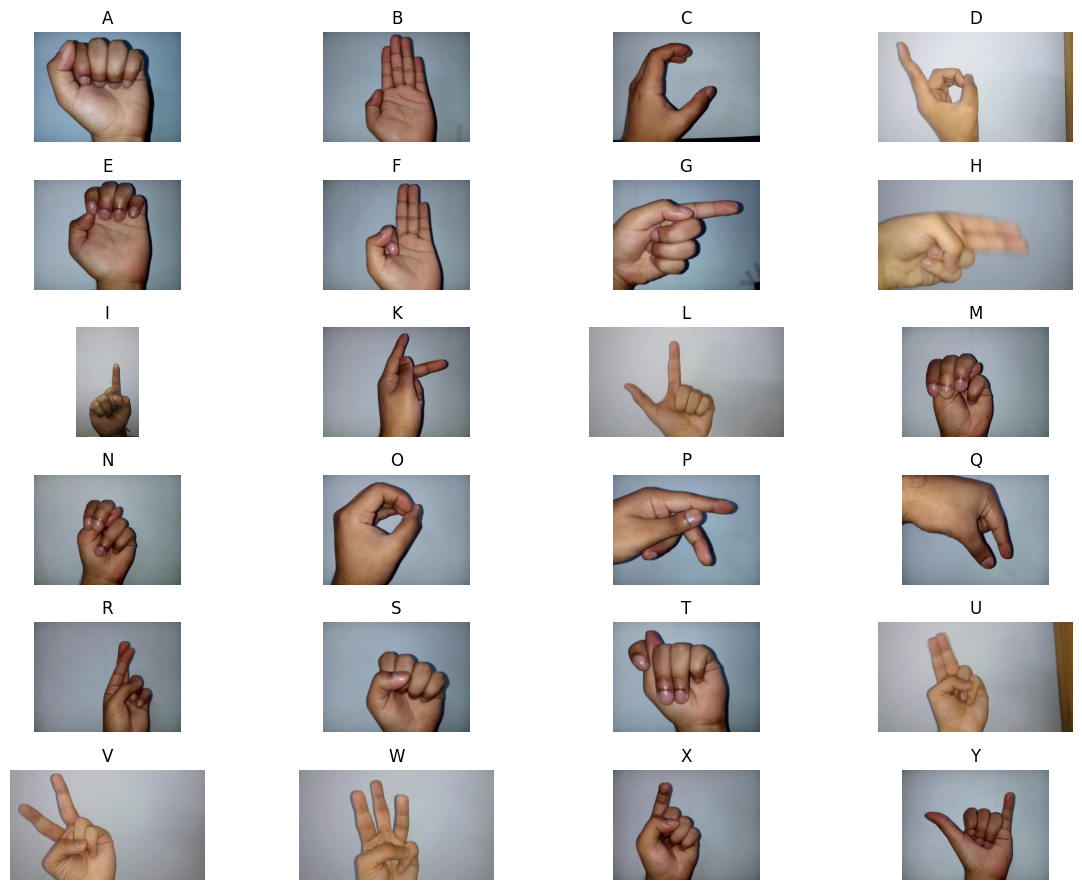

In [ ]:
folders = sorted(os.listdir(data_path))

plt.figure(figsize=(12, 9))
for i in range(24):
    folder = folders[i]
    path = os.path.join(data_path, folder)
    image = os.listdir(path)[0]
    img = Image.open(os.path.join(path, image))

    plt.subplot(6, 4, i + 1)
    plt.imshow(img)
    plt.title(folder)
    plt.axis('off')

plt.tight_layout()
plt.show()

## INSIGHT
- All images in the dataset must be resized to a fixed dimension , as CNN models require consistent input sizes for effective training and to prevent shape mismatches.

#**6. SPLIT CONFIGURATION**

In [ ]:
target_dir = '/content/drive/MyDrive/IndianSignLangProject/Splitted_dir'
split_ratio = {'train': 0.7, 'val': 0.15, 'test': 0.15}
random.seed(42)

#**7. CREATING SPLIT FOLDERS**

In [ ]:
splits = ['train', 'val', 'test']
labels = os.listdir(data_path)

for split in splits:
    for label in labels:
        Path(f'{target_dir}/{split}/{label}').mkdir(parents=True, exist_ok=True)

#**8. SPLITTING AND MOVING FILES**

In [ ]:
for label in labels:
    files = os.listdir(os.path.join(data_path, label))
    random.shuffle(files)

    total = len(files)
    train_end = int(total * split_ratio['train'])
    val_end = train_end + int(total * split_ratio['val'])

    train_files = files[:train_end]
    val_files = files[train_end:val_end]
    test_files = files[val_end:]

    for split, split_files in zip(['train', 'val', 'test'], [train_files, val_files, test_files]):
        for file in split_files:
            src = os.path.join(data_path, label, file)
            dst = os.path.join(target_dir, split, label, file)
            shutil.copy2(src, dst)

print("Dataset splitted successfully!!!!!!")

Dataset splitted successfully!!!!!!


#**9. RESIZING IMAGES TO A UNIFORM SHAPE (128x128)**

In [ ]:
img_size = 128
labels = os.listdir(data_path)
def get_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[..., ::-1]  # Convert BGR to RGB
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data, dtype="object")

#**10. DATA PREPROCESSING**

In [ ]:
train = get_data(r'/content/drive/MyDrive/IndianSignLangProject/Splitted_dir/train')
print("There are {} images in train dataset".format(len(train)))
print("Each image has a dimension of : {}".format(train[i][0].shape))


There are 3469 images in train dataset
Each image has a dimension of : (128, 128, 3)


In [ ]:
test = get_data(r'/content/drive/MyDrive/IndianSignLangProject/Splitted_dir/test')
print("There are {} images in test dataset".format(len(test)))
print("Each image has a dimension of : {}".format(test[i][0].shape))

There are 767 images in test dataset
Each image has a dimension of : (128, 128, 3)


In [ ]:
val = get_data(r'/content/drive/MyDrive/IndianSignLangProject/Splitted_dir/val')

print("There are {} images in val dataset".format(len(val)))
print("Each image has a dimension of : {}".format(val[i][0].shape))

There are 736 images in val dataset
Each image has a dimension of : (128, 128, 3)


In [ ]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
  x_train.append(np.array(feature))
  y_train.append(int(label))

for feature, label in test:
    x_test.append(np.array(feature))
    y_test.append(int(label))

for feature, label in val:
  x_val.append(np.array(feature))
  y_val.append(int(label))

In [ ]:
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [ ]:
y_train = np.array(y_train)
y_test = np.array(y_test)
y_val = np.array(y_val)

#**11. ONE-HOT ENCODING**

In [ ]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)
y_val = to_categorical(y_val, num_classes)

#**12. DATA AUGMENTATION**

In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=True,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

#**13. MODEL CREATION**

In [ ]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=(128,128,3)))
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.2))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(24, activation='softmax'))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 124, 124, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 120, 120, 32)   │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 60, 60, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 60, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 58, 58, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 56, 56, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    12,845,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 24)             │         6,168 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,934,968 (49.34 MB)

 Trainable params: 12,934,968 (49.34 MB)

 Non-trainable params: 0 (0.00 B)

#**14. MODEL COMPILATION AND FITTING**

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=32, epochs=12, validation_data=(x_val, y_val), verbose = True)

Epoch 1/12
109/109 ━━━━━━━━━━━━━━━━━━━━ 349s 3s/step - accuracy: 0.1013 - loss: 3.1207 - val_accuracy: 0.5000 - val_loss: 1.6838
Epoch 2/12
109/109 ━━━━━━━━━━━━━━━━━━━━ 344s 3s/step - accuracy: 0.4630 - loss: 1.7090 - val_accuracy: 0.7269 - val_loss: 0.9416
Epoch 3/12
109/109 ━━━━━━━━━━━━━━━━━━━━ 342s 3s/step - accuracy: 0.6293 - loss: 1.1544 - val_accuracy: 0.8329 - val_loss: 0.6298
Epoch 4/12
109/109 ━━━━━━━━━━━━━━━━━━━━ 342s 3s/step - accuracy: 0.6821 - loss: 0.9352 - val_accuracy: 0.8872 - val_loss: 0.3775
Epoch 5/12
109/109 ━━━━━━━━━━━━━━━━━━━━ 342s 3s/step - accuracy: 0.7829 - loss: 0.6351 - val_accuracy: 0.9266 - val_loss: 0.2608
Epoch 6/12
109/109 ━━━━━━━━━━━━━━━━━━━━ 342s 3s/step - accuracy: 0.8082 - loss: 0.5711 - val_accuracy: 0.9457 - val_loss: 0.1903
Epoch 7/12
109/109 ━━━━━━━━━━━━━━━━━━━━ 341s 3s/step - accuracy: 0.8296 - loss: 0.4905 - val_accuracy: 0.9565 - val_loss: 0.1389
Epoch 8/12
109/109 ━━━━━━━━━━━━━━━━━━━━ 342s 3s/step - accuracy: 0.8461 - loss: 0.4403 - val_accu

#**15. VISUALIZING PLOTS**

##**15.1. ACCURACY PLOT**

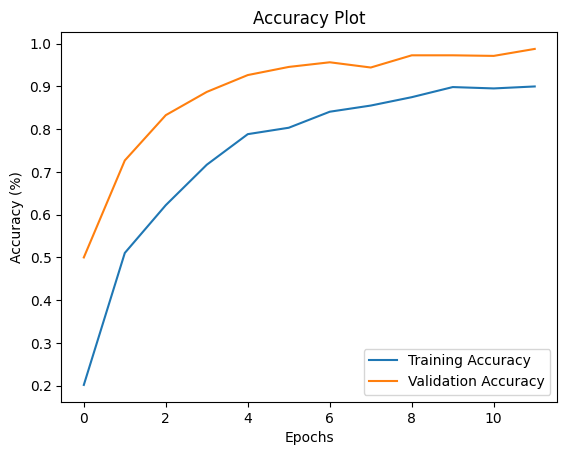

In [ ]:
plt.figure()
plt.plot(history.history['accuracy'], label = "Training Accuracy")
plt.plot(history.history['val_accuracy'], label = "Validation Accuracy")
plt.title("Accuracy Plot")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()

##**15.2. LOSS PLOT**

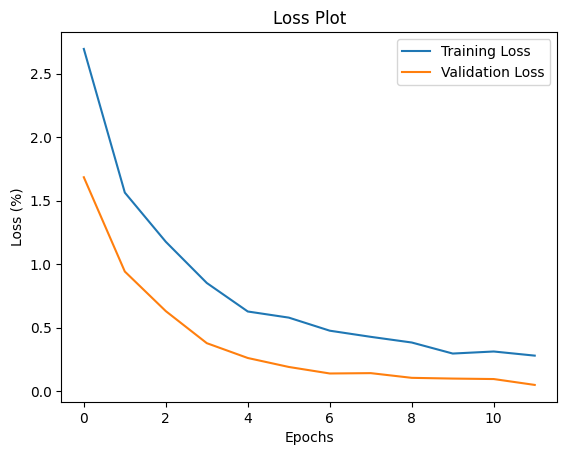

In [ ]:
plt.figure()
plt.plot(history.history['loss'], label = "Training Loss")
plt.plot(history.history['val_loss'], label = "Validation Loss")
plt.title("Loss Plot")
plt.xlabel("Epochs")
plt.ylabel("Loss (%)")
plt.legend()
plt.show()

#**16. MODEL EVALUATION**

In [ ]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("\n")
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1])

24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 449ms/step - accuracy: 0.9804 - loss: 0.0811
Loss of the model is -  0.06783662736415863


24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 431ms/step - accuracy: 0.9804 - loss: 0.0811
Accuracy of the model is -  0.9804432988166809


In [ ]:
predictions = model.predict(x_test)

predicted_classes = predictions.argmax(axis=1)
print(predicted_classes)

24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 426ms/step
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  5  2
  2  2  2  2  3  3  3  3  3  3  3  3  3  3  3  3 12  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  4  4  4  4  4  3  4  9  4  4  4
 12  4  4  4  4  4  4  4  4  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  6  6  6  6  6  6  6  6
  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6
  6  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7
  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  8  8  8  8  8  8  8  8 23
  8  8  8  8  8  8  8  8 23  8  9  9  9  9  9  9  9  9  9  9  9  9  9  9
  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10 10 10 10 10 10 10  2 10 10
 10 10 10

#**17. CONFUSION MATRIX**

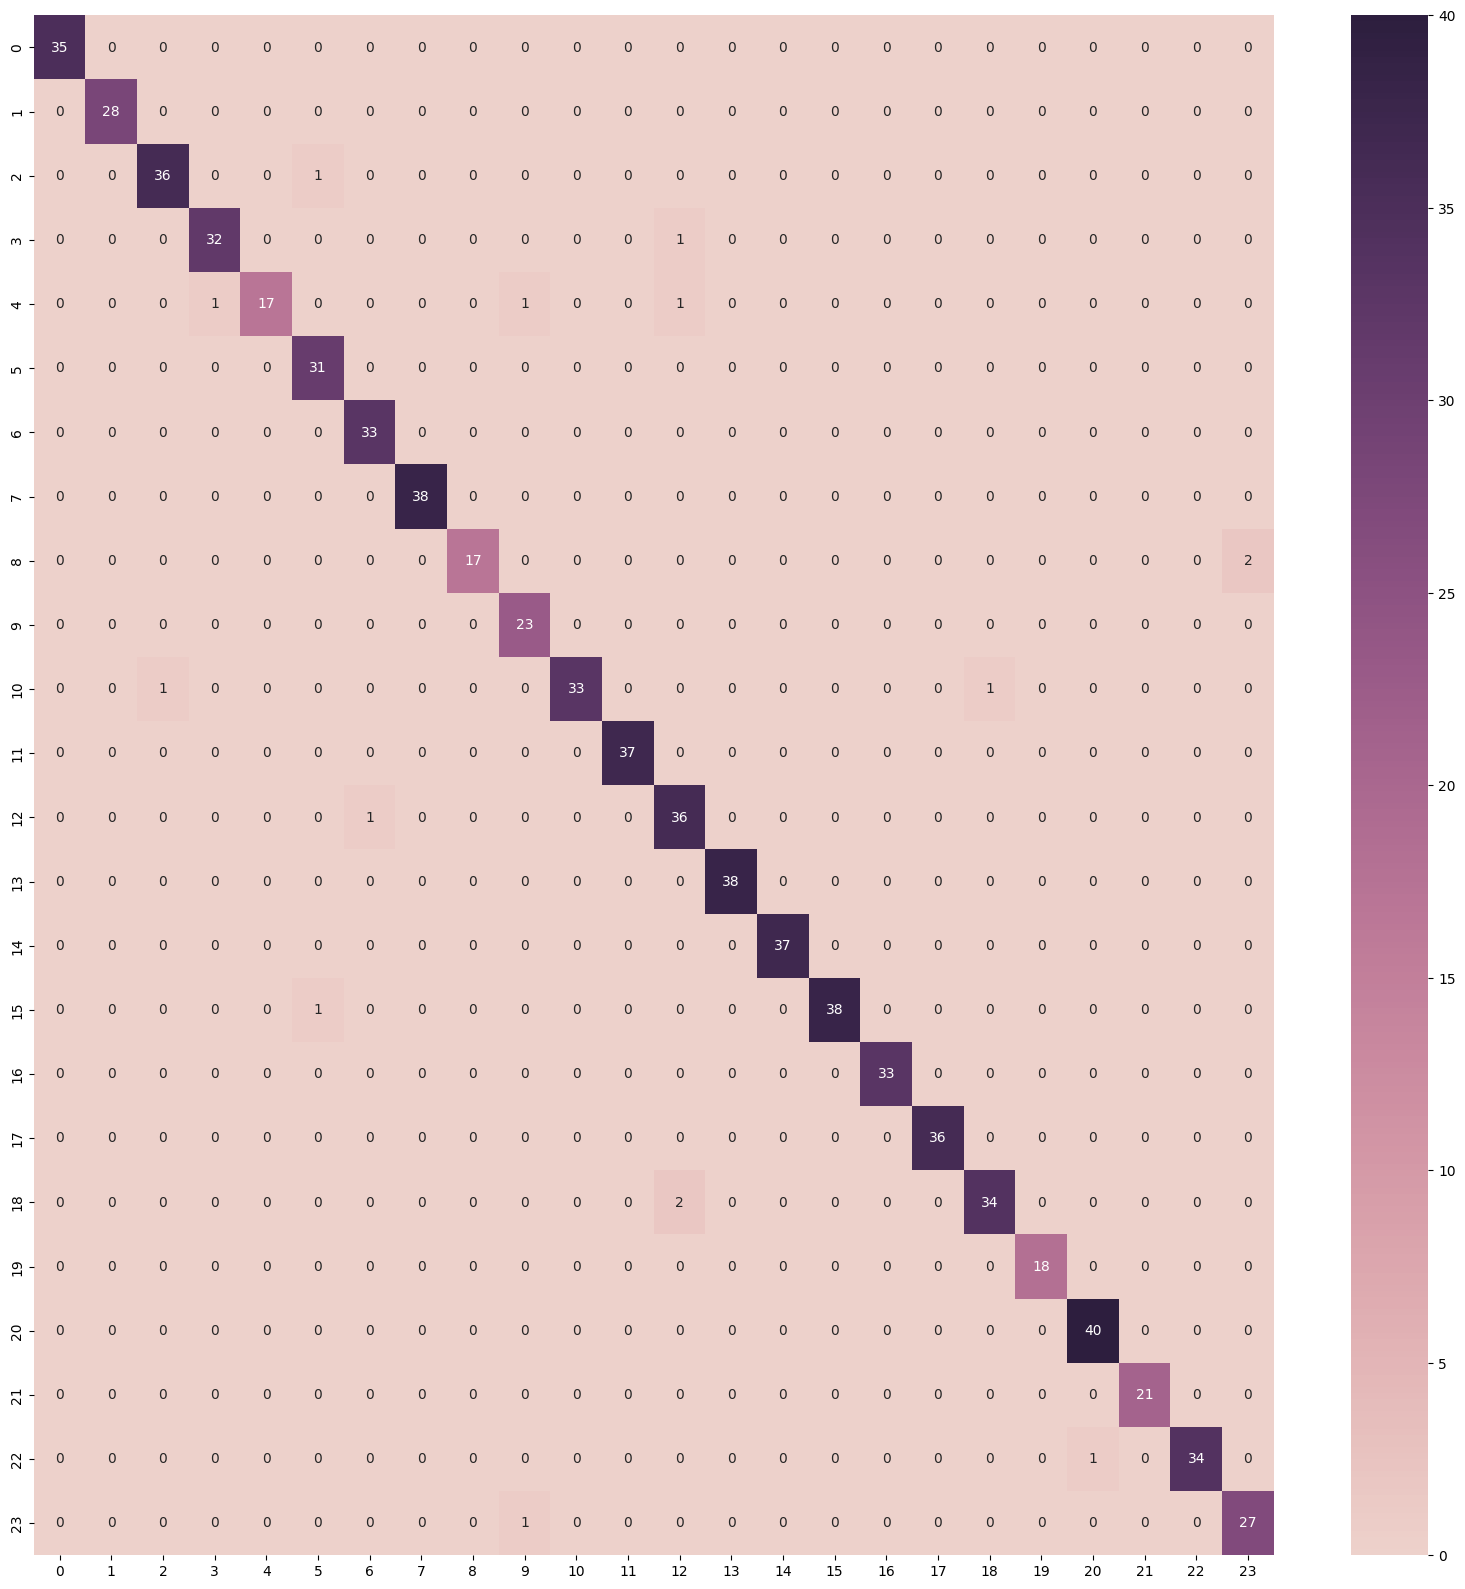

In [ ]:
cm = confusion_matrix(y_test, predicted_classes)
df_cm = pd.DataFrame(cm, index=[i for i in range(num_classes)], columns=[i for i in range(num_classes)])

plt.figure(figsize=(20, 20))
sns.heatmap(df_cm, annot=True, cmap=sns.cubehelix_palette(as_cmap=True))
plt.show()

#**18. CLASSIFICATION REPORT**

In [ ]:
print("Classification Report:\n")
print(classification_report(y_test, predicted_classes, digits=4))

Classification Report:

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        35
           1     1.0000    1.0000    1.0000        28
           2     0.9730    0.9730    0.9730        37
           3     0.9697    0.9697    0.9697        33
           4     1.0000    0.8500    0.9189        20
           5     0.9394    1.0000    0.9688        31
           6     0.9706    1.0000    0.9851        33
           7     1.0000    1.0000    1.0000        38
           8     1.0000    0.8947    0.9444        19
           9     0.9200    1.0000    0.9583        23
          10     1.0000    0.9429    0.9706        35
          11     1.0000    1.0000    1.0000        37
          12     0.9000    0.9730    0.9351        37
          13     1.0000    1.0000    1.0000        38
          14     1.0000    1.0000    1.0000        37
          15     1.0000    0.9744    0.9870        39
          16     1.0000    1.0000    1.0000        33
   

#**19. TEST-IMAGE PREDICTIONS (GREEN: CORRECT, RED: INCORRECT)**

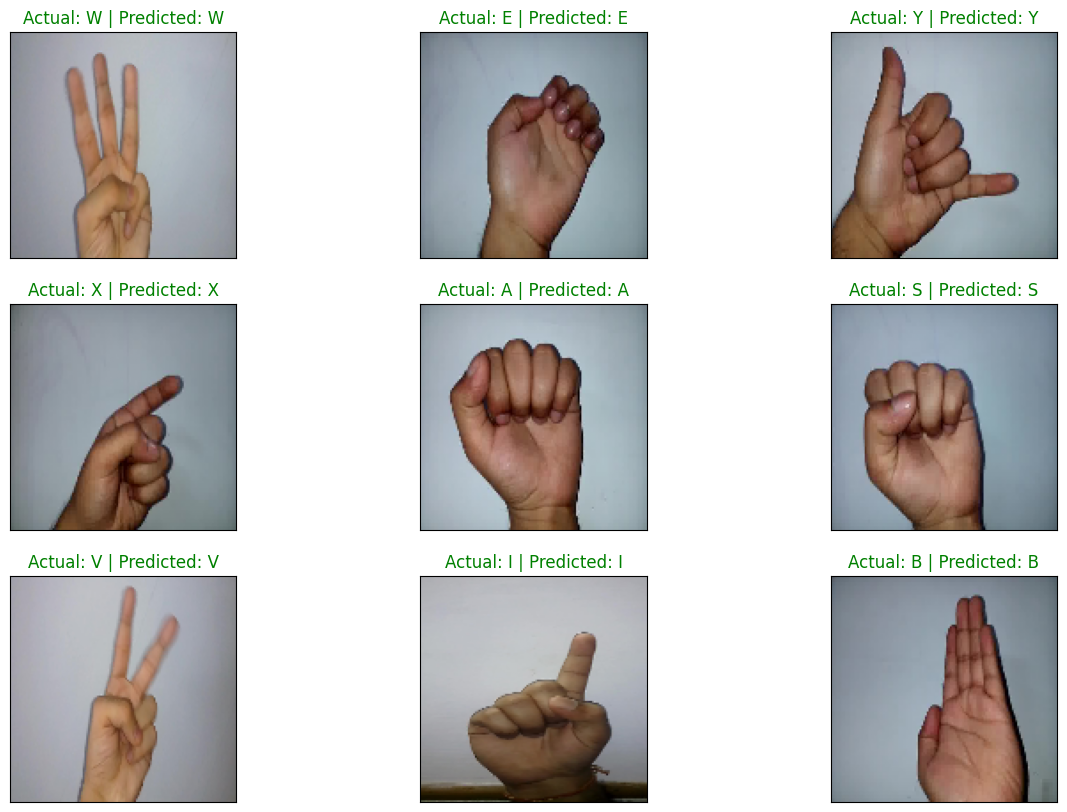

In [ ]:
if y_test.ndim > 1:
    y_test = y_test.argmax(axis=1)

fig = plt.figure(figsize=(15, 10))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=9, replace=False)):
    ax = fig.add_subplot(3, 3, i + 1, xticks=[], yticks=[])
    image = x_test[idx].squeeze()
    ax.imshow(image, cmap='gray')

    pred_label = predicted_classes[idx]
    true_label = y_test[idx]

    ax.set_title(f"Actual: {labels[true_label]} | Predicted: {labels[pred_label]}",
                 color=("green" if pred_label == true_label else "red"))

#**20. CONCLUSION**

- The Convolutional Neural Network (CNN) developed for Indian Sign Language (ISL) recognition demonstrated excellent performance with a high test accuracy of **98.04%** and a low loss of **0.0678**, indicating robust learning and effective generalization across 24 distinct hand gesture classes.

- These results emphasize the model’s ability to accurately identify and distinguish various ISL gestures, which is crucial for enhancing accessibility solutions, communication support for the hearing and speech impaired, and real-time gesture-based interaction systems.

- To further improve performance and deployability, future enhancements may include experimenting with deeper or more efficient architectures, applying extensive data augmentation to strengthen underrepresented classes, conducting hyperparameter tuning, and incorporating transfer learning using lightweight models like MobileNetV2, EfficientNet, or ResNet50 for optimized inference on edge devices.

#**CHALLENGES FACED**

- High Number of Classes **(24 CLASSES)** and insufficient data  
- Complexity of the model
- Took more computational time
- Hardware limitations